## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Extract object points and image points for camera calibration.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(100)

cv2.destroyAllWindows()

## Camera Calibration

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistortion
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./output_images/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./output_images/dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig("./output_images/calibration1.jpg")

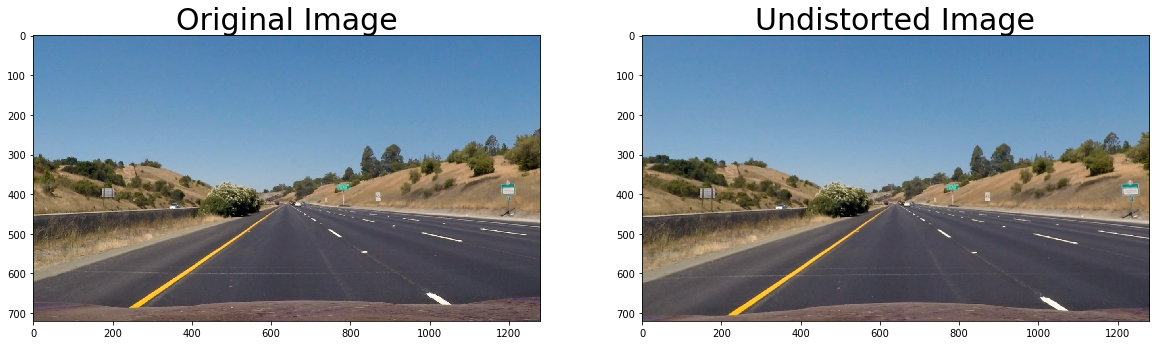

In [15]:
# Test undistortion on an image
img = cv2.imread('./test_images/straight_lines1.jpg')
_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./output_images/straight_lines1_undist.jpg',_undistorted)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
_undistorted = cv2.cvtColor(_undistorted, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig("./output_images/straight_lines1_undistortion.jpg")

In [16]:
def ThresholdedBinary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #return color_binary
    return combined_binary

_ThresBinary = ThresholdedBinary(_undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(_undistorted)
ax1.set_title('Original Image', fontsize=40)
#ax2.imshow(_result)
ax2.imshow(_ThresBinary, cmap='gray')
ax2.set_title('Combined S channel and gradient thresholds', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/straight_lines1_combined_thresholds.jpg")

In [24]:
offset = 0
_center = img_size[0]/2
_top_left     = [_center-85,450]
_top_right    = [_center+85,450]
_bottom_right = [_center+800, img_size[1]-20]
_bottom_left  = [_center-800, img_size[1]-20]
src = np.float32([ _top_left, _top_right, _bottom_right, _bottom_left])
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
_M = cv2.getPerspectiveTransform(src, dst)
_Minv = cv2.getPerspectiveTransform(dst, src)
_warped = cv2.warpPerspective(_ThresBinary, _M, img_size, flags=cv2.INTER_LINEAR)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(_ThresBinary, cmap='gray')
ax1.set_title('Original', fontsize=40)
#ax1.plot(_top_left[0],_top_left[1],'r+')
#ax1.plot(_top_right[0],_top_right[1],'r+')
#ax1.plot(_bottom_right[0],_bottom_right[1],'r+')
#ax1.plot(_bottom_left[0],_bottom_left[1],'r+')
ax1.plot([_top_left[0],_top_right[0]], [_top_left[1],_top_right[1]], color='r', lw=2)
ax1.plot([_top_left[0],_bottom_left[0]], [_top_left[1],_bottom_left[1]], color='r', lw=2)
ax1.plot([_bottom_right[0],_top_right[0]], [_bottom_right[1],_top_right[1]], color='r', lw=2)
ax1.plot([_bottom_right[0],_bottom_left[0]], [_bottom_right[1],_bottom_left[1]], color='r', lw=2)
#ax2.imshow(_result)
ax2.imshow(_warped, cmap='gray')
ax2.set_title('Warped', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/straight_lines1_perspective_transform.jpg")

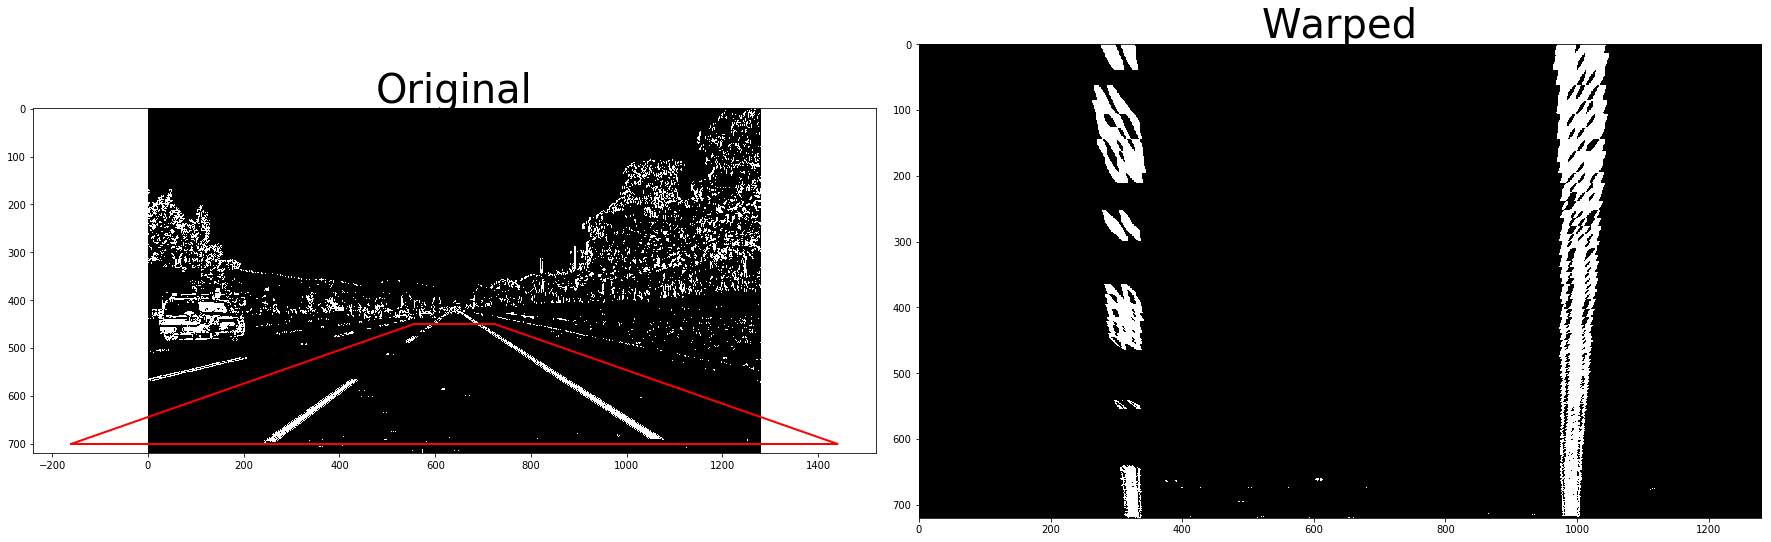

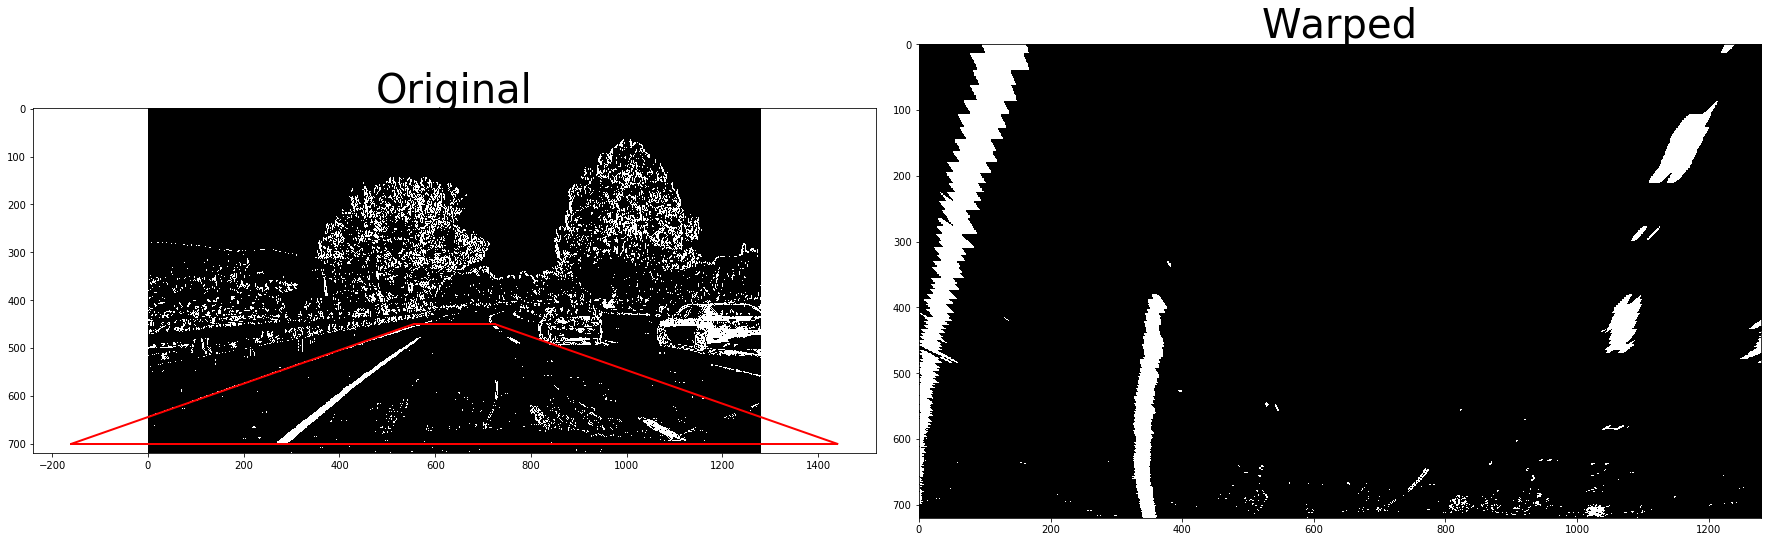

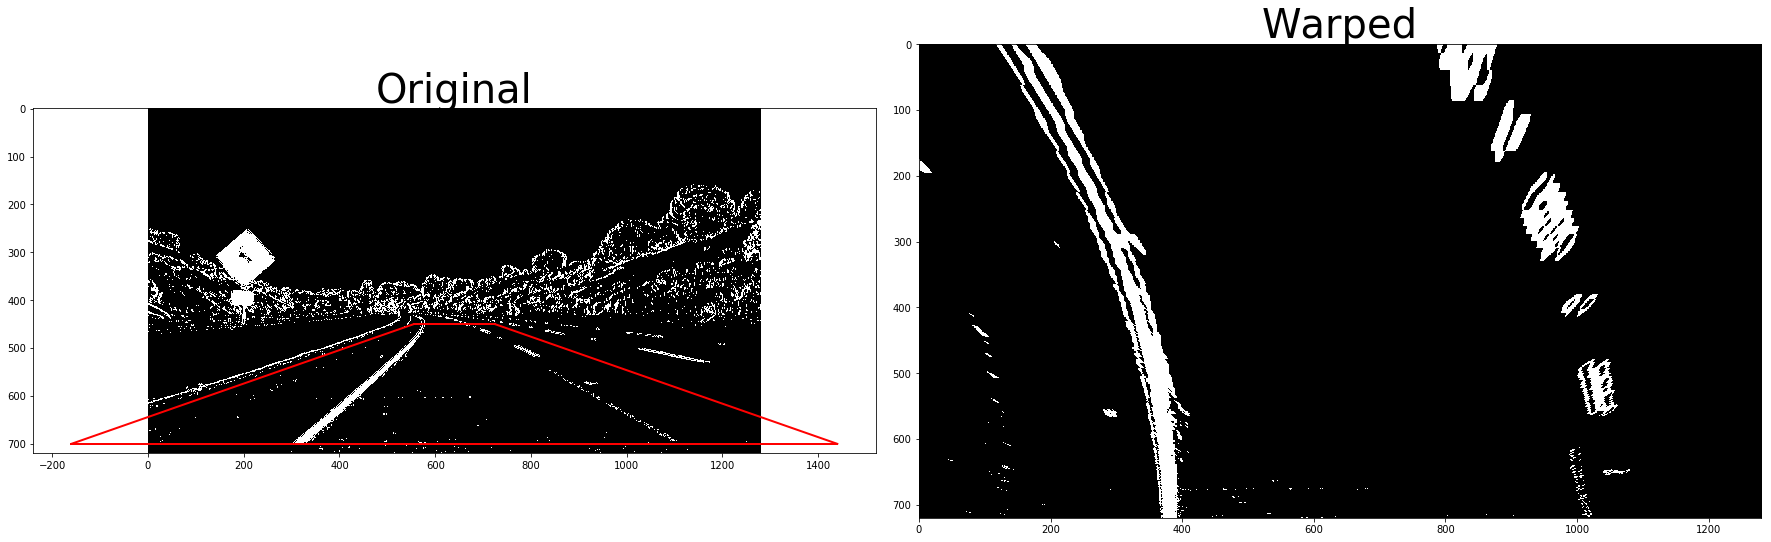

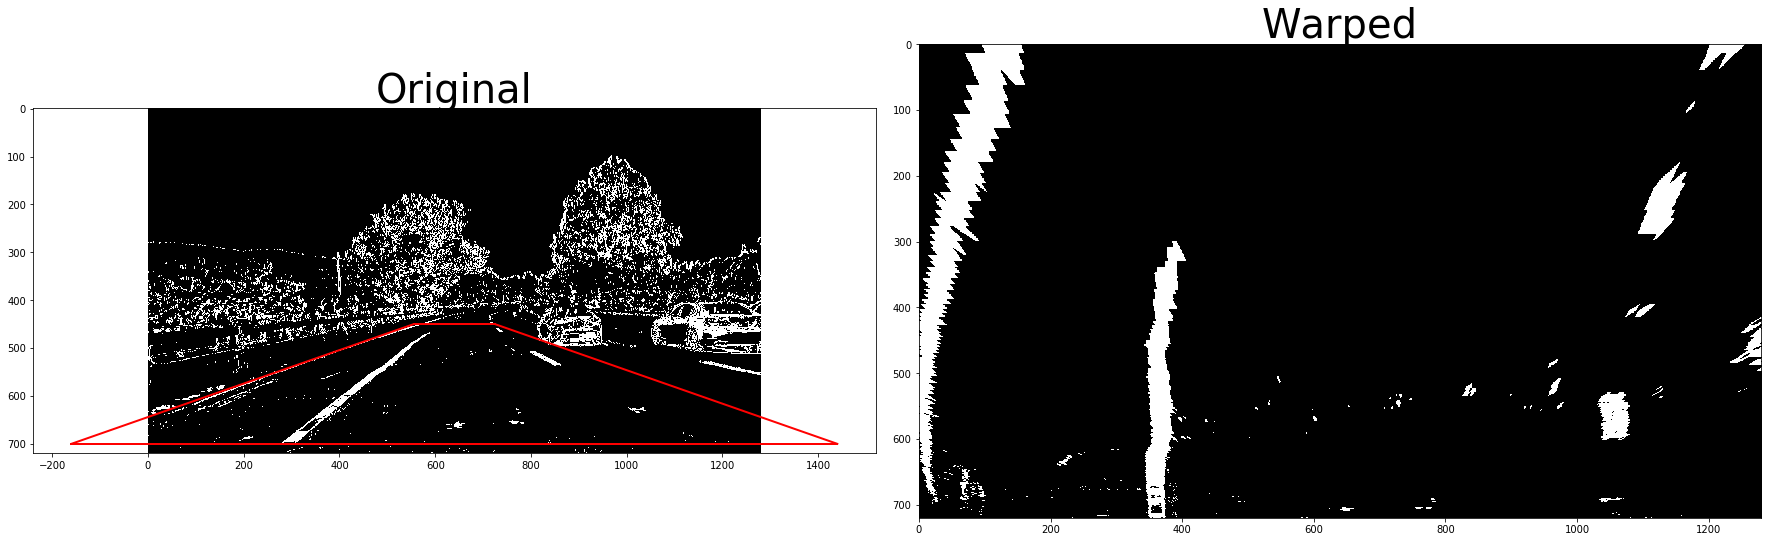

In [23]:
def Test_Perspective(_filename):
    img = cv2.imread(_filename)
    _undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _undistorted = cv2.cvtColor(_undistorted, cv2.COLOR_BGR2RGB)
    _ThresBinary = ThresholdedBinary(_undistorted)
    _warped = cv2.warpPerspective(_ThresBinary, _M, img_size, flags=cv2.INTER_LINEAR)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(_ThresBinary, cmap='gray')
    ax1.set_title('Original', fontsize=40)
    #ax1.plot(_top_left[0],_top_left[1],'r+')
    #ax1.plot(_top_right[0],_top_right[1],'r+')
    #ax1.plot(_bottom_right[0],_bottom_right[1],'r+')
    #ax1.plot(_bottom_left[0],_bottom_left[1],'r+')
    ax1.plot([_top_left[0],_top_right[0]], [_top_left[1],_top_right[1]], color='r', lw=2)
    ax1.plot([_top_left[0],_bottom_left[0]], [_top_left[1],_bottom_left[1]], color='r', lw=2)
    ax1.plot([_bottom_right[0],_top_right[0]], [_bottom_right[1],_top_right[1]], color='r', lw=2)
    ax1.plot([_bottom_right[0],_bottom_left[0]], [_bottom_right[1],_bottom_left[1]], color='r', lw=2)
    #ax2.imshow(_result)
    ax2.imshow(_warped, cmap='gray')
    ax2.set_title('Warped', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Test_Perspective('./test_images/straight_lines2.jpg')
Test_Perspective('./test_images/test1.jpg')
Test_Perspective('./test_images/test2.jpg')
Test_Perspective('./test_images/test3.jpg')
Test_Perspective('./test_images/test4.jpg')
Test_Perspective('./test_images/test5.jpg')
Test_Perspective('./test_images/test6.jpg')

In [7]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
#window_height = 200
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        if abs(window_centroids[-1][0]-l_center)>80:
            l_center=window_centroids[-1][0]
        if abs(window_centroids[-1][1]-r_center)>80:
            r_center=window_centroids[-1][1]
        window_centroids.append((l_center,r_center))
    return window_centroids

def DetectLaneLines(_warped):
    _window_centroids = find_window_centroids(_warped, window_width, window_height, margin)
    if len(_window_centroids) > 0:
        # Points used to draw all the left and right windows
        _l_points = np.zeros_like(_warped)
        _r_points = np.zeros_like(_warped)
        # Go through each level and draw the windows
        for level in range(0,len(_window_centroids)):
            # Window_mask is a function to draw window areas
            _l_mask = window_mask(window_width,window_height,_warped,_window_centroids[level][0],level)
            _r_mask = window_mask(window_width,window_height,_warped,_window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            #_l_points[(_l_points == 255) | ((_l_mask == 1) ) ] = 255
            #_r_points[(_r_points == 255) | ((_r_mask == 1) ) ] = 255
            _l_points[(_l_points == 1) | ((_l_mask == 1)&(_warped==1) ) ] = 1
            _r_points[(_r_points == 1) | ((_r_mask == 1)&(_warped==1) ) ] = 1
        return _l_points, _r_points


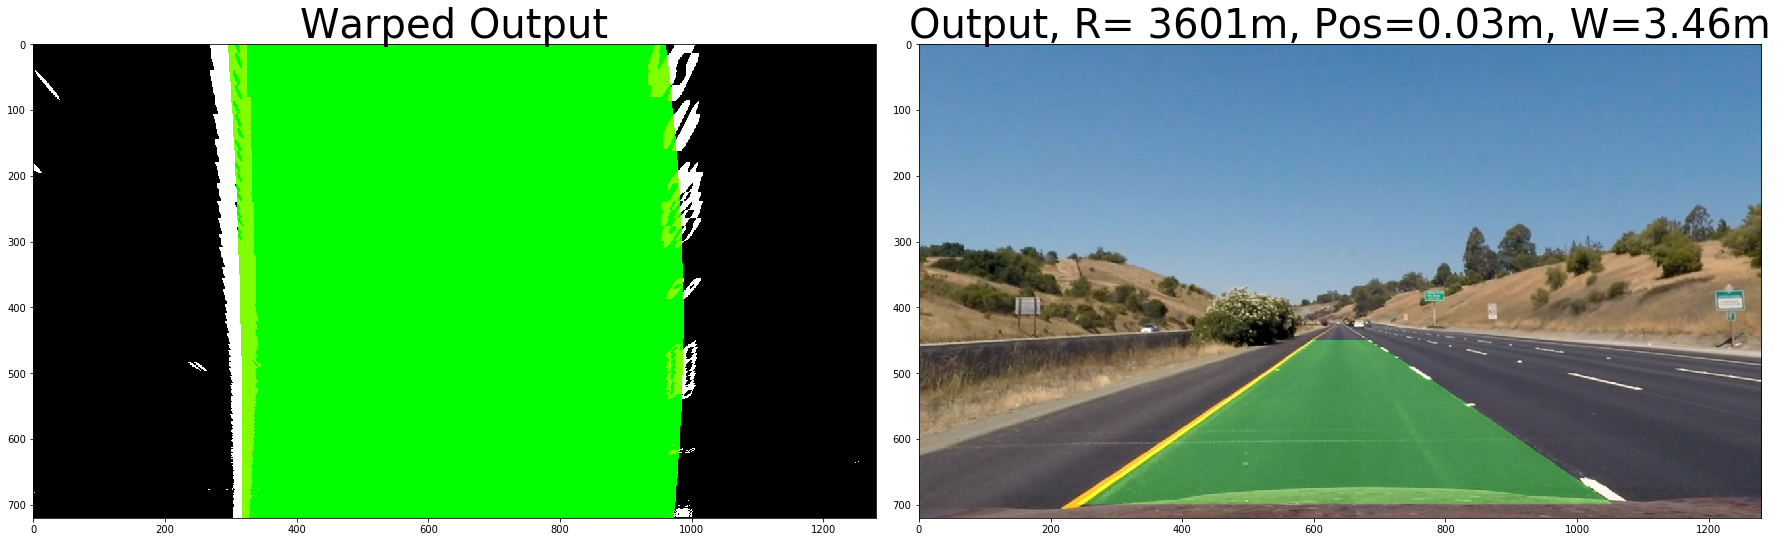

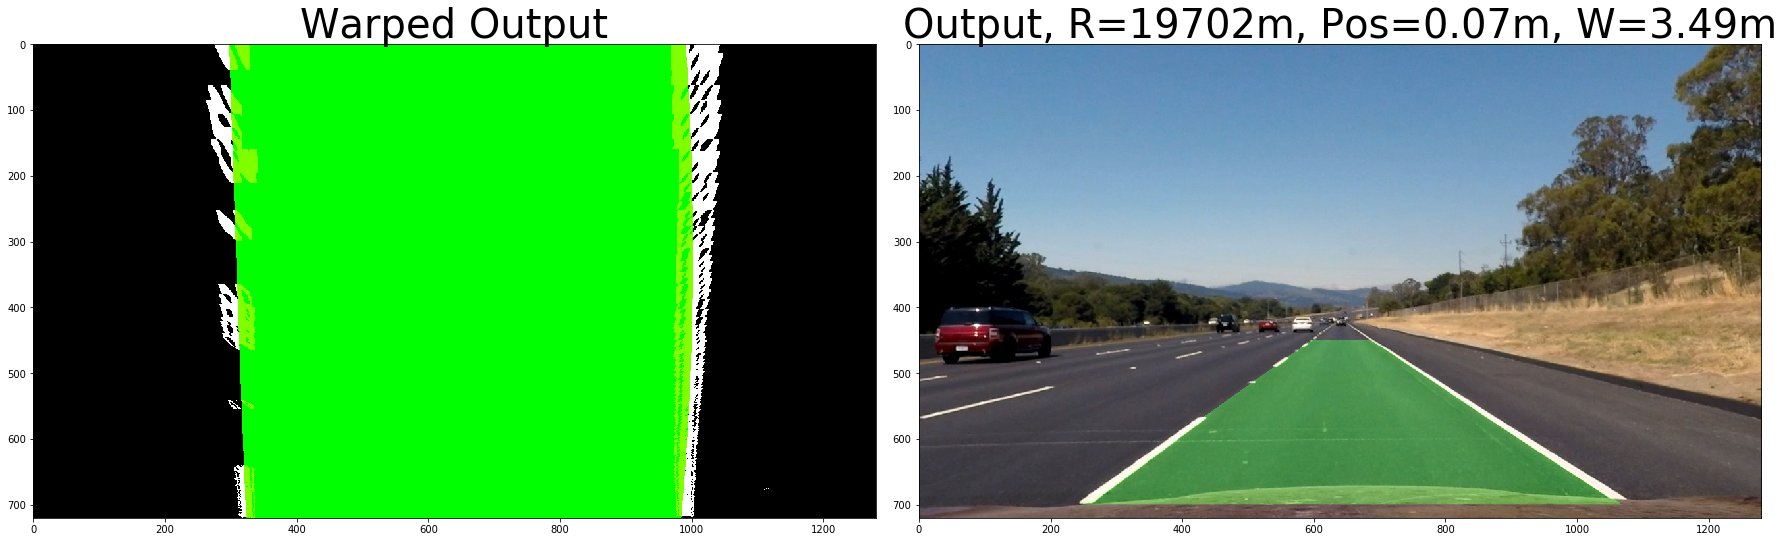

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


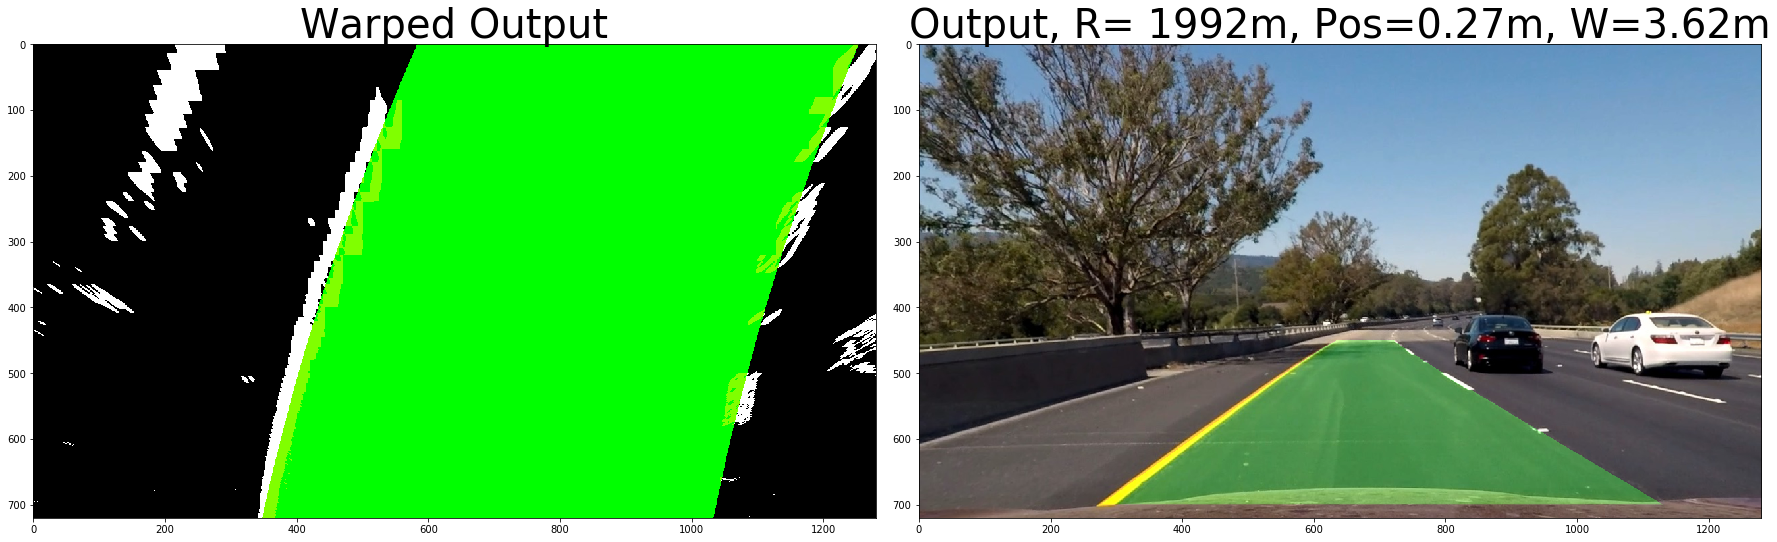

In [25]:
def PolyFitting(_binary_warped):
    _line_dots = np.nonzero(_binary_warped)
    _xs = _line_dots[1]
    _ys = _line_dots[0]
    _y_eval = np.max(_ys)
    _fit = np.polyfit(_ys, _xs, 2)
    _ploty = np.linspace(0, img_size[1]-1, num=img_size[1])
    _fitx = _fit[0]*_ploty**2 + _fit[1]*_ploty + _fit[2]
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    _ym_per_pix = 15*2.7/720 # meters per pixel in y dimension
    _xm_per_pix = 3.7/700 # meters per pixel in x dimension
    _fit_cr = np.polyfit(_ys*_ym_per_pix, _xs*_xm_per_pix, 2)
    _curverad = ((1 + (2*_fit_cr[0]*_y_eval*_ym_per_pix + _fit_cr[1])**2)**1.5) / np.absolute(2*_fit_cr[0])
    
    
    _lane_pos = ((_fit[0]*_y_eval**2 + _fit[1]*_y_eval + _fit[2])-img_size[0]/2)*_xm_per_pix
    
    return _fitx, _curverad, _lane_pos, _fit

def CalcPoly(_fit):
    _ploty = np.linspace(0, img_size[1]-1, num=img_size[1])
    _fitx = _fit[0]*_ploty**2 + _fit[1]*_ploty + _fit[2]
    return _fitx

    
def DetectLanes(_filename, _save=False):
    _ploty = np.linspace(0, img_size[1]-1, num=img_size[1])
    img = cv2.imread(_filename)
    _undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _undistorted = cv2.cvtColor(_undistorted, cv2.COLOR_BGR2RGB)
    _ThresBinary = ThresholdedBinary(_undistorted)
    _warped = cv2.warpPerspective(_ThresBinary, _M, img_size, flags=cv2.INTER_LINEAR)
    _l_points, _r_points = DetectLaneLines(_warped)
    _left_fitx,  _left_curverad, _left_line_pos, _left_fit    = PolyFitting(_l_points)
    _right_fitx, _right_curverad, _right_line_pos, _right_fit = PolyFitting(_r_points)
    
    _pts_left = np.array([np.transpose(np.vstack([_left_fitx, _ploty]))])
    _pts_right = np.array([np.flipud(np.transpose(np.vstack([_right_fitx, _ploty])))])
    _pts = np.hstack((_pts_left, _pts_right))
    
    _zero_channel = np.zeros_like(_l_points) # create a zero color channel
    _template = np.array(cv2.merge((_l_points+_r_points, _zero_channel, _zero_channel))*255, np.uint8) # make window pixels green
    _warpage= np.dstack((_warped, _warped, _warped))*255 # making the original road pixels 3 color channels
    _unwarped = cv2.warpPerspective(_template, _Minv, img_size, flags=cv2.INTER_LINEAR)
    
    cv2.fillPoly(_warpage, np.int_([_pts]), (0,255, 0))
    _lane_warp = np.dstack((_zero_channel, _zero_channel, _zero_channel))
    cv2.fillPoly(_lane_warp, np.int_([_pts]), (0,255, 0))
    _lane_unwarped = cv2.warpPerspective(_lane_warp, _Minv, img_size)
    
    _warped_output = cv2.addWeighted(_warpage, 1, _template, 0.5, 0.0) # overlay the orignal road image with window results
    _final_output = cv2.addWeighted(_undistorted, 1, _lane_unwarped, 0.3, 0)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(_warped_output)
    ax1.set_title('Warped Output', fontsize=40)
    ax2.imshow(_final_output)
    ax2.set_title('Output'+", R={0:5d}m, Pos={1:.2f}m, W={2:.2f}m".format(int((_left_curverad+_right_curverad)/2), (_left_line_pos+_right_line_pos)/2, _right_line_pos-_left_line_pos), fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    #print('rad', _left_curverad, 'm', _right_curverad, 'm')
    #print('position', (_left_line_pos+_right_line_pos)/2, 'm')
    if _save:
        plt.savefig("./output_images/"+_filename.split('/')[-1])

DetectLanes('./test_images/straight_lines1.jpg', True)
DetectLanes('./test_images/straight_lines2.jpg', True)
DetectLanes('./test_images/test1.jpg', True)
DetectLanes('./test_images/test2.jpg', True)
DetectLanes('./test_images/test3.jpg', True)
DetectLanes('./test_images/test4.jpg', True)
DetectLanes('./test_images/test5.jpg', True)
DetectLanes('./test_images/test6.jpg', True)

In [11]:
class DetectedLines():
    def __init__(self, N=20):
        self.N = N
        self.bestx = None
        self.fits_left = []
        self.fits_right = []
        self.best_fit_left = None
        self.best_fit_right = None
        self.current_fit_left = None
        self.current_fit_right = None
        self.Rs_left = []
        self.Rs_right = []
        self.left_xs=None
        self.right_xs=None
        self.radius_of_curvature = None
        self.positions_left = []
        self.positions_right = []
        self.line_base_pos = None
        self.diffs_left = None
        self.diffs_right = None
        self.num_fails_left = None
        self.num_fails_right = None
        self._ploty = np.linspace(0, img_size[1]-1, num=img_size[1])
        self.max_fail_count = 10
    def next(self, _left_fitx,  _left_curverad, _left_line_pos, _left_fit, _right_fitx, _right_curverad, _right_line_pos, _right_fit):
        if self.best_fit_left is not None and self.best_fit_right is not None:
            _best_left_xs  = CalcPoly(np.array([self.best_fit_left[0],self.best_fit_left[1],self.best_fit_left[2]]))
            _best_right_xs = CalcPoly(np.array([self.best_fit_right[0],self.best_fit_right[1],self.best_fit_right[2]]))
            self.diffs_left  = np.max(np.abs(_best_left_xs  - _left_fitx)) #np.std(_best_left_xs, _left_fitx)
            self.diffs_right = np.max(np.abs(_best_right_xs - _right_fitx)) #np.std(_best_right_xs, _right_fitx)

        if self.best_fit_left is None or self.diffs_left is None or self.diffs_left < 50:
            self.num_fails_left = 0
            self.current_fit_left  = [ _left_fit[0], _left_fit[1], _left_fit[2] ]
            self.left_xs  = _left_fitx
        else:
            self.num_fails_left+=1
            self.current_fit_left = self.best_fit_left
            self.left_xs  = CalcPoly(np.array([self.current_fit_left[0],  self.current_fit_left[1],  self.current_fit_left[2]]))
        if self.best_fit_right is None or self.diffs_right is None or self.diffs_right < 50:
            self.num_fails_right = 0
            self.current_fit_right = [ _right_fit[0], _right_fit[1], _right_fit[2]]
            self.right_xs = _right_fitx
        else:
            self.num_fails_right+=1
            self.current_fit_right = self.best_fit_right
            self.right_xs = CalcPoly(np.array([self.current_fit_right[0], self.current_fit_right[1], self.current_fit_right[2]]))

        if self.num_fails_left==0 or self.num_fails_left > self.max_fail_count:
            self.fits_left.append([_left_fit[0],_left_fit[1],_left_fit[2]])
            if len(self.fits_left)>self.N:
                self.fits_left.pop(0)
            self.best_fit_left = [0.,0.,0.]
            for _cfit in  self.fits_left:
                for _i in range(3):
                    self.best_fit_left[_i]+=_cfit[_i]
            for _i in range(3):
                self.best_fit_left[_i] = self.best_fit_left[_i]/float(len(self.fits_left))
            self.Rs_left.append(_left_curverad)
            if len(self.Rs_left)>self.N:
                self.Rs_left.pop(0)
            self.positions_left.append(_left_line_pos)
            if len(self.positions_left)>self.N:
                self.positions_left.pop(0)

        if self.num_fails_right==0 or self.num_fails_right > self.max_fail_count:
            self.fits_right.append([_right_fit[0],_right_fit[1],_right_fit[2]])
            if len(self.fits_right)>self.N:
                self.fits_right.pop(0)
            self.best_fit_right = [0.,0.,0.]
            for _cfit in  self.fits_right:
                for _i in range(3):
                    self.best_fit_right[_i]+=_cfit[_i]
            for _i in range(3):
                self.best_fit_right[_i] = self.best_fit_right[_i]/float(len(self.fits_right))
            self.Rs_right.append(_right_curverad)
            if len(self.Rs_right)>self.N:
                self.Rs_right.pop(0)
            self.positions_right.append(_right_line_pos)
            if len(self.positions_right)>self.N:
                self.positions_right.pop(0)

            self.radius_of_curvature = ( np.mean(np.array(self.Rs_left)) + np.mean(np.array(self.Rs_right)) )/2.
            self.line_base_pos = ( np.mean(np.array(self.positions_left)) + np.mean(np.array(self.positions_right)) )/2.


In [12]:
 _lines = DetectedLines()

def process_image(img):
    _ploty = np.linspace(0, img_size[1]-1, num=img_size[1])
    _undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _undistorted = cv2.cvtColor(_undistorted, cv2.COLOR_BGR2RGB)
    _ThresBinary = ThresholdedBinary(_undistorted)
    _warped = cv2.warpPerspective(_ThresBinary, _M, img_size, flags=cv2.INTER_LINEAR)
    _l_points, _r_points = DetectLaneLines(_warped)
    _left_fitx,  _left_curverad, _left_line_pos, _left_fit  = PolyFitting(_l_points)
    _right_fitx, _right_curverad, _right_line_pos, _right_fit = PolyFitting(_r_points)
    
    _lines.next(_left_fitx,  _left_curverad, _left_line_pos, _left_fit, _right_fitx, _right_curverad, _right_line_pos, _right_fit)
    
    _pts_left = np.array([np.transpose(np.vstack([_lines.left_xs, _ploty]))])
    _pts_right = np.array([np.flipud(np.transpose(np.vstack([_lines.right_xs, _ploty])))])
    _pts = np.hstack((_pts_left, _pts_right))
    
    _zero_channel = np.zeros_like(_l_points) # create a zero color channel
    _template = np.array(cv2.merge((_l_points+_r_points, _zero_channel, _zero_channel))*255, np.uint8) # make window pixels green
    _warpage= np.dstack((_warped, _warped, _warped))*255 # making the original road pixels 3 color channels
    _unwarped = cv2.warpPerspective(_template, _Minv, img_size, flags=cv2.INTER_LINEAR)
    #_warped_output = np.dstack((_l_points, _r_points, _zero_channel))*255
    
    cv2.fillPoly(_warpage, np.int_([_pts]), (0,255, 0))
    _lane_warp = np.dstack((_zero_channel, _zero_channel, _zero_channel))
    cv2.fillPoly(_lane_warp, np.int_([_pts]), (0,255, 0))
    _lane_unwarped = cv2.warpPerspective(_lane_warp, _Minv, img_size)
    
    _warped_output = cv2.addWeighted(_warpage, 1, _template, 0.5, 0.0) # overlay the orignal road image with window results
    result = cv2.addWeighted(_undistorted, 1, _lane_unwarped, 0.3, 0)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,"R={0:5d}m, Pos={1:.2f}m, W={2:.2f}m".format(int(_lines.radius_of_curvature), _lines.line_base_pos, _right_line_pos-_left_line_pos),(100,100),font, 2,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,"R={0:5d}m/{0:5d}m, Vehicle Position={1:.2f}m".format(int(_left_curverad),int(_right_curverad), (_left_line_pos+_right_line_pos)/2),(100,100),font, 2,(255,255,255),2,cv2.LINE_AA)
    
    return result

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def CreateVideo(_mp4_file):
    _lines = DetectedLines()
    #clip1 = VideoFileClip(_mp4_file).subclip(0,20)
    clip1 = VideoFileClip(_mp4_file)
    _clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time _clip.write_videofile('output_images/'+_mp4_file, audio=False)

#CreateVideo('project_video.mp4')
CreateVideo('challenge_video.mp4')
CreateVideo('harder_challenge_video.mp4')


[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [01:39<00:00,  4.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

Wall time: 1min 40s
[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4


100%|█████████████████████████████████████▉| 1199/1200 [04:18<00:00,  4.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video.mp4 

Wall time: 4min 20s
